In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
from xoa.regrid import grid2loc

In [4]:
import dask_hpcconfig
from distributed import Client

In [3]:
dask_hpcconfig.print_clusters()

Available clusters:
 • local: local
 • datarmor-local: local
 • datarmor: pbs
 • datarmor-seq: pbs


In [5]:
cluster = dask_hpcconfig.cluster("datarmor-local")
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 14
Total threads: 28,Total memory: 200.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52652,Workers: 14
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 200.00 GiB
Comm: tcp://127.0.0.1:37732,Total threads: 2
Dashboard: http://127.0.0.1:54563/status,Memory: 14.29 GiB
Nanny: tcp://127.0.0.1:51831,


In [12]:
client.close()

In [6]:
locs = xr.open_dataset('/scale/project/shom_simurep/public_no_ftp/PROJETS/IberArgo/JJ_2008/date_good.zarr',engine='zarr')
dsk = locs[['lon','lat','time']].stack(k=("trajectory","obs"))
dsk = dsk.isel(k=slice(0,-1,10))
dsk = dsk.set_coords(["lon","lat","time"])
dsk = dsk.drop_vars(['k','trajectory','obs'])
dsk

<xarray.Dataset> Size: 689kB
Dimensions:  (k: 28695)
Coordinates:
    lon      (k) float64 230kB -17.0 -16.96 -16.92 ... -10.4 -10.73 -11.02
    lat      (k) float64 230kB 33.0 32.99 32.98 32.97 ... 39.53 39.45 39.63
    time     (k) datetime64[ns] 230kB 2008-06-01T12:00:00 ... 2008-08-01T08:0...
Dimensions without coordinates: k
Data variables:
    *empty*
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        ArgoParticleArgoFloatKernelAdvectionRK4KeepInWate...
    parcels_mesh:           spherical
    parcels_version:        3.0.2

In [7]:
files=glob('/scale/project/shom_simurep/public_no_ftp/PROJETS/IberArgo/GIGATL/NEW_DOMAIN_WITH_DEPTHS/*.nc')
files.sort()

In [31]:
gigatl = xr.open_mfdataset(files[77:150])
gigatl = gigatl.rename({'lat_rho':'lat','lon_rho':'lon'})
gigatl = gigatl.assign_coords(sig_rho=gigatl['sig_rho'])
gigatl = gigatl.set_coords(["depth_rho"])
t0,t1=[gigatl.time.min().values,gigatl.time.max().values]

In [33]:
gigatl[['ptemp','sal','depth_rho']]

<xarray.Dataset> Size: 142GB
Dimensions:    (time: 73, sig_rho: 100, y_rho: 1400, x_rho: 1155)
Coordinates:
    depth_rho  (time, sig_rho, y_rho, x_rho) float32 47GB dask.array<chunksize=(1, 100, 1400, 1155), meta=np.ndarray>
    lon        (y_rho, x_rho) float64 13MB dask.array<chunksize=(1400, 1155), meta=np.ndarray>
    lat        (y_rho, x_rho) float64 13MB dask.array<chunksize=(1400, 1155), meta=np.ndarray>
  * time       (time) datetime64[ns] 584B 2008-05-30 2008-05-31 ... 2008-08-10
  * sig_rho    (sig_rho) int64 800B 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: y_rho, x_rho
Data variables:
    ptemp      (time, sig_rho, y_rho, x_rho) float32 47GB dask.array<chunksize=(1, 100, 1400, 1155), meta=np.ndarray>
    sal        (time, sig_rho, y_rho, x_rho) float32 47GB dask.array<chunksize=(1, 100, 1400, 1155), meta=np.ndarray>

In [34]:
xloc_t = grid2loc(gigatl['ptemp'], dsk_s)
xloc_s = grid2loc(gigatl['sal'], dsk_s)
xloc_d = grid2loc(gigatl['depth_rho'], dsk_s)

/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 13.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/xoa/grid.py:618: XoaWarning: Cannot convert to curvilinear to rectangular grid since since coordinate 'lon' is not constant along one of its dimensions
  xoa_warn(msg)
/home1/datahome/kbalem/conda-env/xarray2024K/lib/python3.10/site-packages/distributed/client.py:3358: UserWarning: Sending large graph of size 13.94 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.


In [83]:
xloc_t

<xarray.DataArray 'ptemp' (k: 431, sig_rho: 100)> Size: 172kB
array([[ 3.1581094,  3.3279266,  3.4643364, ..., 19.703106 , 19.711502 ,
        19.720085 ],
       [ 3.3349245,  3.5218804,  3.6669183, ..., 19.693556 , 19.708979 ,
        19.729551 ],
       [ 2.0239391,  2.0912728,  2.1152368, ..., 19.566711 , 19.570414 ,
        19.571705 ],
       ...,
       [ 4.977209 ,  5.2481947,  5.439384 , ..., 17.037363 , 17.05837  ,
        17.097595 ],
       [ 1.9551263,  1.977415 ,  1.9978034, ..., 17.008545 , 17.134872 ,
        17.388767 ],
       [ 2.0125625,  2.018689 ,  2.0305278, ..., 17.019154 , 17.086535 ,
        17.207253 ]], dtype=float32)
Coordinates:
    lon      (k) float64 3kB -16.92 -16.88 -17.0 -17.0 ... -10.54 -10.99 -10.69
    lat      (k) float64 3kB 32.98 32.97 33.45 33.43 ... 39.15 39.19 39.83 39.98
    time     (k) datetime64[ns] 3kB 2008-06-02T08:00:00 ... 2008-06-02T18:00:00
  * sig_rho  (sig_rho) int64 800B 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Dimensions without coordinates: k
Attributes:
    long_name:      Temperature
    units:          degC
    standard_name:  sea_water_potential_temperature

In [55]:
dz = xloc_d.mean('k').values
dz = dz[dz<=2100]
dz = np.ceil(dz).astype(int)+.5
dz

array([2059.5, 1984.5, 1910.5, 1838.5, 1768.5, 1700.5, 1633.5, 1569.5,
       1506.5, 1445.5, 1386.5, 1328.5, 1273.5, 1219.5, 1167.5, 1117.5,
       1068.5, 1022.5,  977.5,  933.5,  891.5,  851.5,  812.5,  774.5,
        738.5,  704.5,  670.5,  638.5,  607.5,  578.5,  549.5,  522.5,
        496.5,  471.5,  446.5,  423.5,  401.5,  380.5,  359.5,  340.5,
        321.5,  303.5,  285.5,  269.5,  253.5,  238.5,  223.5,  209.5,
        196.5,  183.5,  171.5,  159.5,  148.5,  137.5,  127.5,  117.5,
        108.5,   99.5,   90.5,   82.5,   74.5,   67.5,   60.5,   53.5,
         47.5,   41.5,   36.5,   30.5,   25.5,   21.5,   16.5,   12.5,
          9.5,    5.5,    2.5])

In [88]:
from scipy import interpolate

NP,ND = len(xloc_t.k.values),len(dz)

tint = np.zeros([NP,ND])
sint = np.zeros([NP,ND])
lon = np.zeros([NP])
lat = np.zeros([NP])
tim = np.zeros([NP],dtype='datetime64[ns]')

for k in range(NP):
    ft = interpolate.interp1d(xloc_d.isel(k=k).values, xloc_t.isel(k=k).values,bounds_error=False, fill_value=np.nan)    
    fs = interpolate.interp1d(xloc_d.isel(k=k).values, xloc_s.isel(k=k).values,bounds_error=False, fill_value=np.nan)    
    tint[k,:] = ft(dz)
    sint[k,:] = fs(dz)
    lon[k] = xloc_t['lon'].isel(k=k).values
    lat[k] = xloc_t['lat'].isel(k=k).values
    tim[k] = xloc_t['time'].isel(k=k).values

ds_out = xr.Dataset({"ptemp": (["k", "depth"], tint),
                 "sal": (["k", "depth"], sint),
                 "lon": ("k", lon),
                 "lat": ("k", lat),
                 "time": ("k", tim)       
                    },
                coords={"depth": (["depth"], dz)},
)
ds_out

<xarray.Dataset> Size: 528kB
Dimensions:  (k: 431, depth: 75)
Coordinates:
  * depth    (depth) float64 600B 2.06e+03 1.984e+03 1.91e+03 ... 9.5 5.5 2.5
Dimensions without coordinates: k
Data variables:
    ptemp    (k, depth) float64 259kB 4.801 5.071 5.321 ... 17.0 17.08 17.18
    sal      (k, depth) float64 259kB 35.22 35.25 35.28 ... 35.73 35.73 35.73
    lon      (k) float64 3kB -16.92 -16.88 -17.0 -17.0 ... -10.54 -10.99 -10.69
    lat      (k) float64 3kB 32.98 32.97 33.45 33.43 ... 39.15 39.19 39.83 39.98
    time     (k) datetime64[ns] 3kB 2008-06-02T08:00:00 ... 2008-06-02T18:00:00

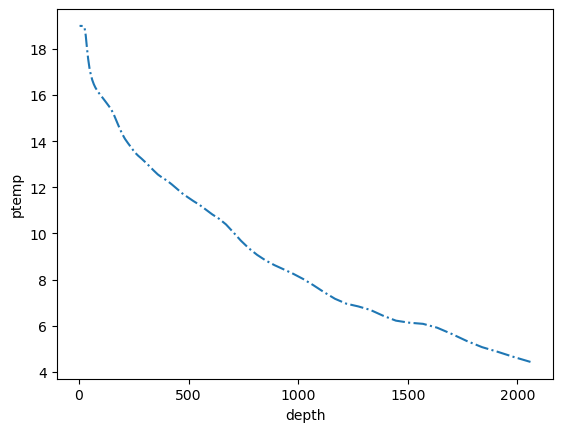

In [89]:
ds_out['ptemp'].isel(k=10).plot.line('-.')

In [91]:
ds_out.to_netcdf('traj_interpolated_for_classif_latlon.nc')